In [1]:
%install_ext https://raw.github.com/cjdrake/ipython-magic/master/gvmagic.py
%load_ext gvmagic

Installed gvmagic.py. To use it, type:
  %load_ext gvmagic


/usr/local/lib/python2.7/dist-packages/IPython/core/magics/extension.py:47: UserWarning: %install_ext` is deprecated, please distribute your extension(s)as a python packages.
  "as a python packages.", UserWarning)


In [2]:
from sklearn import datasets
import pandas as pd

iris_data = pd.read_csv('https://raw.githubusercontent.com/pydata/pandas/master/pandas/tests/data/iris.csv')


In [3]:
iris_data.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth,Name
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


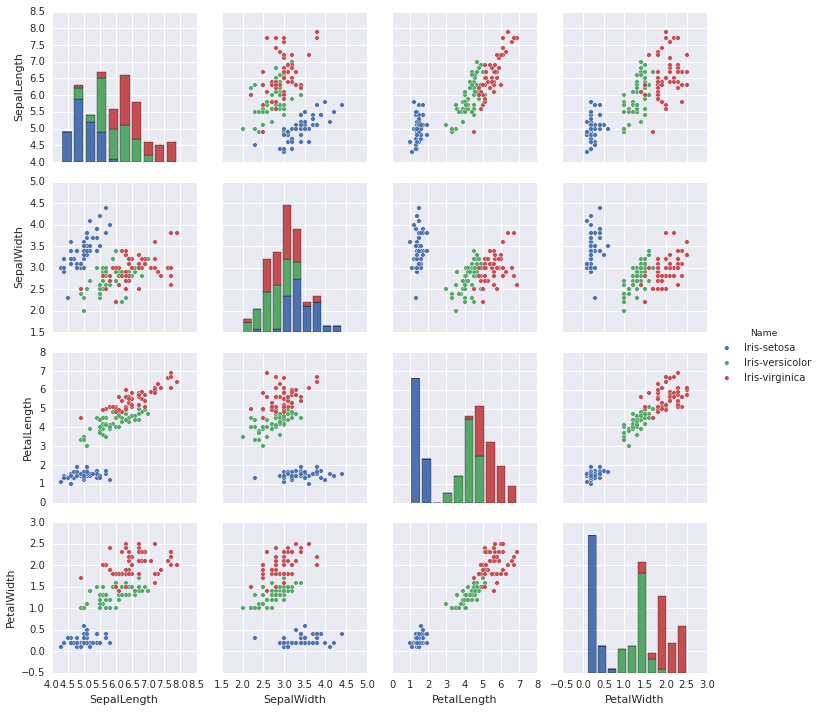

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

sb.pairplot(iris_data, hue='Name')

In [5]:
iris_data['Name'].unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

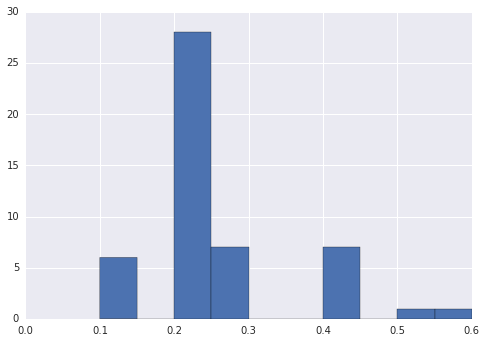

In [6]:
iris_data.loc[iris_data['Name'] == 'Iris-setosa', 'PetalWidth'].hist()

In [7]:
assert(len(iris_data.loc[ iris_data['PetalWidth'].isnull(), :]) == 0 )

In [8]:
import os
try:
    os.makedirs('data/iris')
except:
    pass
iris_data_clean = iris_data.to_csv('data/iris/iris-data-clean.csv', index=False)

In [9]:
iris_data = pd.read_csv('data/iris/iris-data-clean.csv')

In [10]:
assert len(iris_data['Name'].unique()) == 3

In [11]:
# We know that our data set should have no missing measurements
assert len(iris_data.loc[(iris_data['SepalLength'].isnull()) |
                           (iris_data['SepalWidth'].isnull()) |
                           (iris_data['PetalLength'].isnull()) |
                           (iris_data['PetalWidth'].isnull())]) == 0

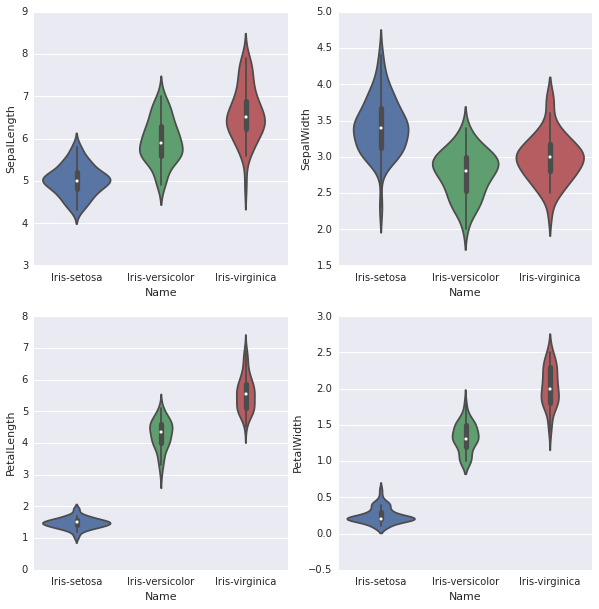

In [12]:
plt.figure(figsize=(10, 10))

for column_index, column in enumerate(iris_data.columns):
    if column == 'Name':
        continue
    plt.subplot(2, 2, column_index + 1)
    sb.violinplot(x='Name', y=column, data=iris_data)

In [13]:
all_inputs = iris_data.iloc[:,0:-1].values
all_inputs[0:10]

array([[ 5.1,  3.5,  1.4,  0.2],
       [ 4.9,  3. ,  1.4,  0.2],
       [ 4.7,  3.2,  1.3,  0.2],
       [ 4.6,  3.1,  1.5,  0.2],
       [ 5. ,  3.6,  1.4,  0.2],
       [ 5.4,  3.9,  1.7,  0.4],
       [ 4.6,  3.4,  1.4,  0.3],
       [ 5. ,  3.4,  1.5,  0.2],
       [ 4.4,  2.9,  1.4,  0.2],
       [ 4.9,  3.1,  1.5,  0.1]])

In [14]:
all_classes = iris_data.iloc[:,-1].values
all_classes[0:10]

array(['Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa',
       'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa',
       'Iris-setosa', 'Iris-setosa'], dtype=object)

In [15]:
from sklearn.cross_validation import train_test_split

(training_inputs,
testing_inputs,
training_classes,
testing_classes) = train_test_split(all_inputs, all_classes, train_size=0.75, random_state=1)

In [16]:
from sklearn.tree import DecisionTreeClassifier

#train the classifier
decision_tree_classifier = DecisionTreeClassifier()
decision_tree_classifier.fit(training_inputs, training_classes)

#validate the classifier on the testing set
decision_tree_classifier.score(testing_inputs, testing_classes)

0.97368421052631582

In [17]:
from sklearn.metrics import confusion_matrix

confusion_matrix(testing_classes, decision_tree_classifier.predict(testing_inputs))

array([[13,  0,  0],
       [ 0, 15,  1],
       [ 0,  0,  9]])

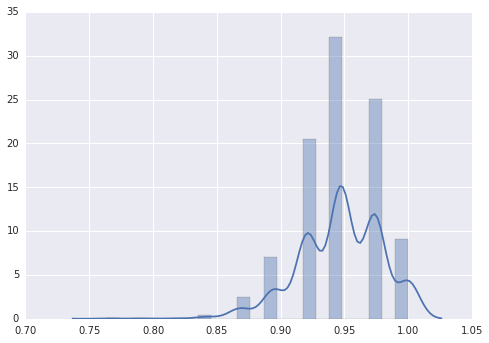

In [18]:
model_accuracies = []

for repetition in range(1000):
    (training_inputs,
     testing_inputs,
     training_classes,
     testing_classes) = train_test_split(all_inputs, all_classes, train_size=0.75)
    
    decision_tree_classifier = DecisionTreeClassifier()
    decision_tree_classifier.fit(training_inputs, training_classes)
    classifier_accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
    model_accuracies.append(classifier_accuracy)
    
sb.distplot(model_accuracies)


## Cross-validation

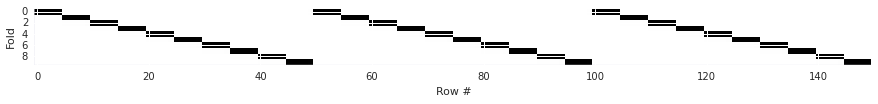

In [19]:
import numpy as np
from sklearn.cross_validation import StratifiedKFold

def plot_cv(cv, n_samples):
    masks = []
    for train, test in cv:
        mask = np.zeros(n_samples, dtype=bool)
        mask[test] = 1
        masks.append(mask)
        
    plt.figure(figsize=(15,15))
    plt.imshow(masks, interpolation='none')
    plt.ylabel('Fold')
    plt.xlabel('Row #')

plot_cv(StratifiedKFold(all_classes, n_folds=10), len(all_classes))


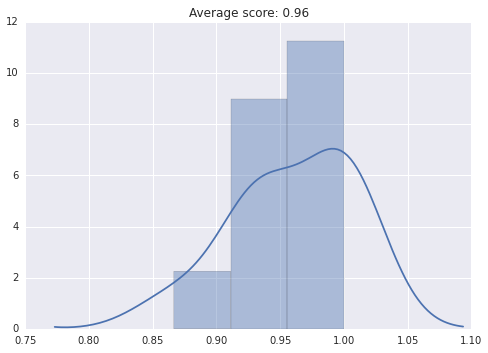

In [20]:
from sklearn.cross_validation import cross_val_score

decision_tree_classifier = DecisionTreeClassifier()

# cross_val_score returns a list of the scores, which we can visualize
# to get a reasonable estimate of our classifier's performance
cv_scores = cross_val_score(decision_tree_classifier, all_inputs, all_classes, cv=10)
sb.distplot(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))


In [21]:
from sklearn.grid_search import GridSearchCV

decision_tree_classifier = DecisionTreeClassifier()

parameter_grid = {'max_depth': [1,2,3,4,5],
                 'max_features': [1,2,3,4]}

cross_validation = StratifiedKFold(all_classes, n_folds=10)

grid_search = GridSearchCV(decision_tree_classifier,
                        param_grid=parameter_grid,
                        cv=cross_validation)
grid_search.fit(all_inputs, all_classes)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.96
Best parameters: {'max_features': 3, 'max_depth': 3}


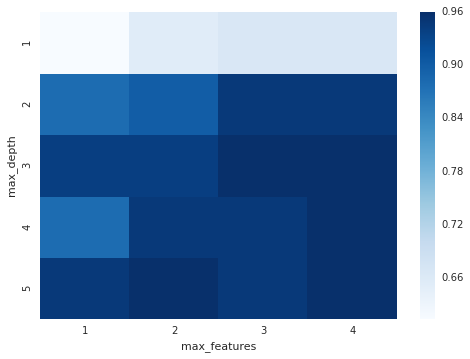

In [22]:
grid_visualization = []

for grid_pair in grid_search.grid_scores_:
    grid_visualization.append(grid_pair.mean_validation_score)
    
grid_visualization = np.array(grid_visualization)
grid_visualization.shape = (5, 4)
sb.heatmap(grid_visualization, cmap='Blues')
plt.xticks(np.arange(4) + 0.5, grid_search.param_grid['max_features'])
plt.yticks(np.arange(5) + 0.5, grid_search.param_grid['max_depth'][::-1])
plt.xlabel('max_features')
plt.ylabel('max_depth')

In [23]:

decision_tree_classifier = DecisionTreeClassifier()

parameter_grid = {'criterion': ['gini', 'entropy'],
                  'splitter': ['best', 'random'],
                  'max_depth': [1, 2, 3, 4, 5],
                  'max_features': [1, 2, 3, 4]}

cross_validation = StratifiedKFold(all_classes, n_folds=10)

grid_search = GridSearchCV(decision_tree_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(all_inputs, all_classes)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.96
Best parameters: {'max_features': 4, 'splitter': 'best', 'criterion': 'gini', 'max_depth': 3}


In [24]:
decision_tree_classifier = grid_search.best_estimator_
decision_tree_classifier

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=4, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')

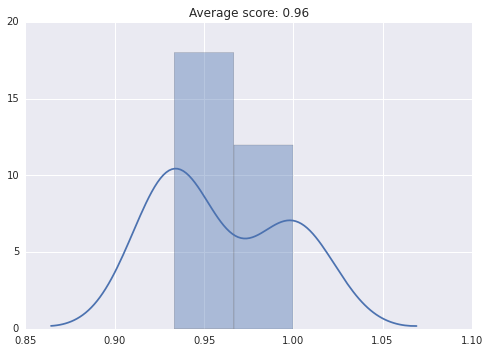

In [25]:
# cross_val_score returns a list of the scores, which we can visualize
# to get a reasonable estimate of our classifier's performance
cv_scores = cross_val_score(decision_tree_classifier, all_inputs, all_classes, cv=10)
sb.distplot(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))

In [26]:
%load_ext gvmagic


The gvmagic extension is already loaded. To reload it, use:
  %reload_ext gvmagic


In [27]:

import sklearn.tree as tree
from sklearn.externals.six import StringIO

with open('iris_dtc.dot', 'w') as out_file:
    out_file = tree.export_graphviz(decision_tree_classifier, out_file=out_file)

In [28]:
from sklearn.ensemble import RandomForestClassifier

random_forest_classifier = RandomForestClassifier()

parameter_grid = {'n_estimators': [5, 10, 25, 50],
                  'criterion': ['gini', 'entropy'],
                  'max_features': [1, 2, 3, 4],
                  'warm_start': [True, False]}

cross_validation = StratifiedKFold(all_classes, n_folds=10)

grid_search = GridSearchCV(random_forest_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(all_inputs, all_classes)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

grid_search.best_estimator_

Best score: 0.966666666667
Best parameters: {'max_features': 1, 'n_estimators': 10, 'criterion': 'gini', 'warm_start': True}


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=1, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0, warm_start=True)

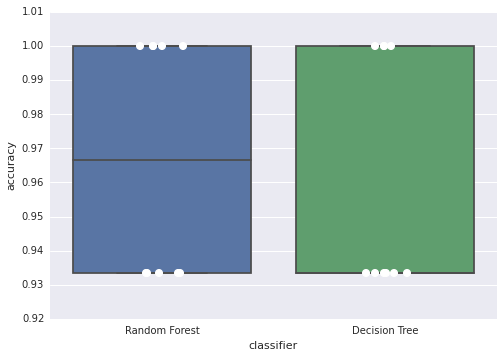

In [29]:
random_forest_classifier = grid_search.best_estimator_

rf_df = pd.DataFrame({'accuracy': cross_val_score(random_forest_classifier, all_inputs, all_classes, cv=10),
                       'classifier': ['Random Forest'] * 10})
dt_df = pd.DataFrame({'accuracy': cross_val_score(decision_tree_classifier, all_inputs, all_classes, cv=10),
                      'classifier': ['Decision Tree'] * 10})
both_df = rf_df.append(dt_df)

sb.boxplot(x='classifier', y='accuracy', data=both_df)
sb.stripplot(x='classifier', y='accuracy', data=both_df, jitter=True, color='white')

## Reproducibility

In [30]:
%install_ext https://raw.githubusercontent.com/rasbt/watermark/master/watermark.py

Installed watermark.py. To use it, type:
  %load_ext watermark


In [31]:
%load_ext watermark


In [32]:
%watermark -a 'Timothy J. Laurent' -nmv --packages numpy,pandas,scikit-learn,matplotlib,Seaborn

Timothy J. Laurent Fri Oct 09 2015 

CPython 2.7.6
IPython 4.0.0

numpy 1.9.2
pandas 0.16.2
scikit-learn 0.16.1
matplotlib 1.4.3
Seaborn 0.6.0

compiler   : GCC 4.8.2
system     : Linux
release    : 3.16.0-4-amd64
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit


[ 5.4  3.9  1.3  0.4]	-->	Iris-setosa	(Actual: Iris-setosa)
[ 6.4  2.9  4.3  1.3]	-->	Iris-versicolor	(Actual: Iris-versicolor)
[ 6.2  2.8  4.8  1.8]	-->	Iris-virginica	(Actual: Iris-virginica)
[ 7.7  2.6  6.9  2.3]	-->	Iris-virginica	(Actual: Iris-virginica)
[ 6.5  3.   5.8  2.2]	-->	Iris-virginica	(Actual: Iris-virginica)
[ 6.7  3.1  4.4  1.4]	-->	Iris-versicolor	(Actual: Iris-versicolor)
[ 6.1  3.   4.6  1.4]	-->	Iris-versicolor	(Actual: Iris-versicolor)
[ 5.7  2.6  3.5  1. ]	-->	Iris-versicolor	(Actual: Iris-versicolor)
[ 6.2  2.9  4.3  1.3]	-->	Iris-versicolor	(Actual: Iris-versicolor)
[ 5.7  2.9  4.2  1.3]	-->	Iris-versicolor	(Actual: Iris-versicolor)


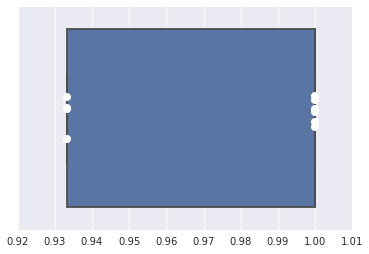

In [33]:
%matplotlib inline
import pandas as pd
import seaborn as sb
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score

iris_data = pd.read_csv('data/iris/iris-data-clean.csv')

all_inputs = iris_data.iloc[:,0:-1].values
all_classes = iris_data.iloc[:,-1].values

random_forest_classifier = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                                max_depth=None, max_features=3, max_leaf_nodes=None,
                                min_samples_leaf=1, min_samples_split=2,
                                min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
                                oob_score=False, random_state=None, verbose=0, warm_start=True)

rf_classifier_scores = cross_val_score(random_forest_classifier, all_inputs, all_classes, cv=10)
sb.boxplot(rf_classifier_scores)
sb.stripplot(rf_classifier_scores, jitter=True, color='white')

(training_inputs,
 testing_inputs,
 training_classes,
 testing_classes) = train_test_split(all_inputs, all_classes, train_size=0.75)

random_forest_classifier.fit(training_inputs, training_classes)

for input_features, prediction, actual in zip(testing_inputs[:10],
                                              random_forest_classifier.predict(testing_inputs[:10]),
                                              testing_classes[:10]):
    print('{}\t-->\t{}\t(Actual: {})'.format(input_features, prediction, actual))



In [34]:
datasets.get_data_home()

'/mldb_data/scikit_learn_data'